In [ ]:
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 18.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


Number of principal components selected: 2

In [ ]:
pca = PCA(n_components=2)
scores_pca = pca.fit_transform(X)

In [ ]:
# Apply HDBSCAN
# Try different min_cluster_size values to find optimal clustering
min_cluster_sizes = [100, 500, 1000, 5000, 10000, 15000]
min_samples_range = [5, 10, 15, 20]

best_score = -1
best_params = None
best_clusterer = None

for min_cluster_size in min_cluster_sizes:
    for min_samples in min_samples_range:
        clusterer = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            cluster_selection_epsilon=0.0,
            metric='euclidean'
        )
        cluster_labels = clusterer.fit_predict(scores_pca)

        # Skip if all points are noise (-1) or only one cluster
        if len(np.unique(cluster_labels)) <= 1:
            continue

        # Calculate validity metrics (only for non-noise points)
        mask = cluster_labels != -1
        if np.sum(mask) > 1:  # Need at least 2 non-noise points
            score = np.mean(clusterer.probabilities_[mask])

            # Calculate additional metrics
            try:
                # Filter out noise points for metric calculation
                X_clean = scores_pca[mask]
                labels_clean = cluster_labels[mask]

                # Only calculate metrics if we have at least 2 clusters and 2 points per cluster
                if len(np.unique(labels_clean)) >= 2:
                    silhouette = silhouette_score(X_clean, labels_clean)
                    calinski = calinski_harabasz_score(X_clean, labels_clean)
                    davies = davies_bouldin_score(X_clean, labels_clean)

                    current_metrics = {
                        'silhouette': silhouette,
                        'calinski': calinski,
                        'davies': davies
                    }

                    if score > best_score:
                        best_score = score
                        best_params = (min_cluster_size, min_samples)
                        best_clusterer = clusterer
                        best_metrics = current_metrics
            except Exception as e:
                print(f"Metrics calculation failed for parameters {min_cluster_size}, {min_samples}: {str(e)}")
                continue

print(f"\nBest parameters found:")
print(f"min_cluster_size: {best_params[0]}")
print(f"min_samples: {best_params[1]}")
print(f"Average clustering probability: {best_score:.4f}")

print("\nClustering Metrics (excluding noise points):")
print(f"Silhouette Coefficient: {best_metrics['silhouette']:.4f}")
print(f"Calinski-Harabasz Index: {best_metrics['calinski']:.4f}")
print(f"Davies-Bouldin Index: {best_metrics['davies']:.4f}")

In [ ]:
# Use best parameters for final clustering
final_labels = best_clusterer.fit_predict(scores_pca)
n_clusters = len(set(final_labels)) - (1 if -1 in final_labels else 0)
n_noise = list(final_labels).count(-1)

print(f"\nClustering Results:")
print(f"Number of clusters: {n_clusters}")
print(f"Number of noise points: {n_noise}")
print(f"Percentage of noise points: {100 * n_noise / len(final_labels):.2f}%")

# Create results DataFrame
df_segm_pca_hdbscan = pd.concat([
    X.reset_index(drop=True),
    pd.DataFrame(scores_pca, columns=['Component 1', 'Component 2'])
], axis=1)

df_segm_pca_hdbscan['Cluster'] = final_labels
df_segm_pca_hdbscan['Cluster_Prob'] = best_clusterer.probabilities_



Clustering Results:
Number of clusters: 2
Number of noise points: 24770
Percentage of noise points: 36.80%


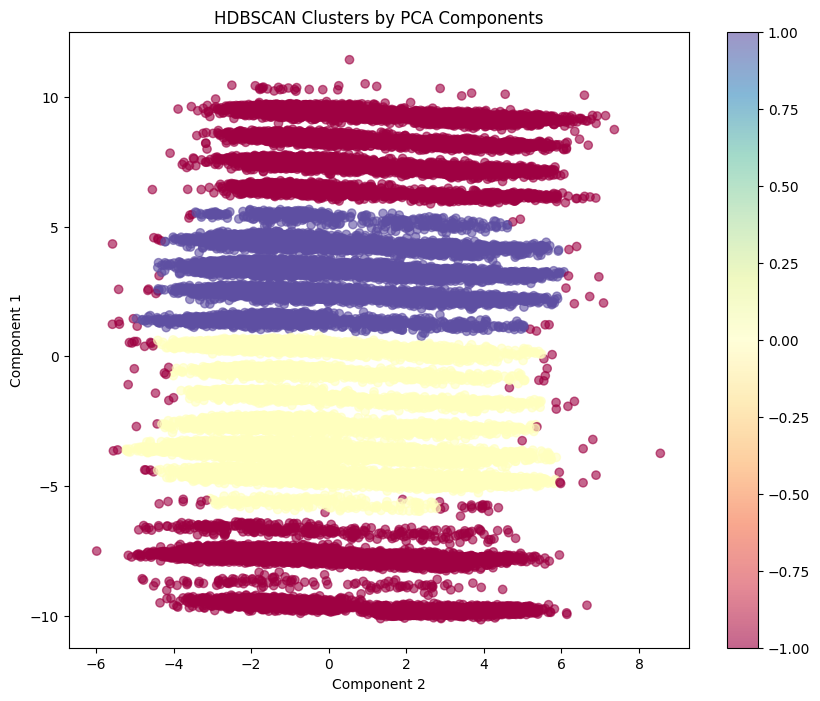

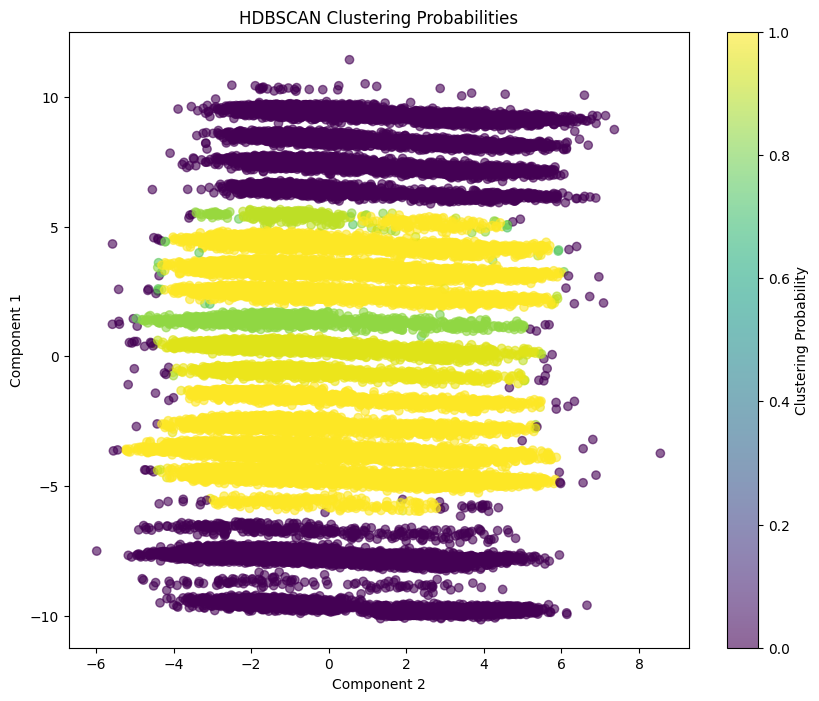

In [ ]:
# Visualize clusters
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_segm_pca_hdbscan['Component 2'],
    df_segm_pca_hdbscan['Component 1'],
    c=df_segm_pca_hdbscan['Cluster'],
    cmap='Spectral',
    alpha=0.6
)
plt.colorbar(scatter)
plt.title('HDBSCAN Clusters by PCA Components')
plt.xlabel('Component 2')
plt.ylabel('Component 1')
plt.show()

# Visualize clustering probabilities
plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_segm_pca_hdbscan['Component 2'],
    df_segm_pca_hdbscan['Component 1'],
    c=df_segm_pca_hdbscan['Cluster_Prob'],
    cmap='viridis',
    alpha=0.6
)
plt.colorbar(scatter, label='Clustering Probability')
plt.title('HDBSCAN Clustering Probabilities')
plt.xlabel('Component 2')
plt.ylabel('Component 1')
plt.show()

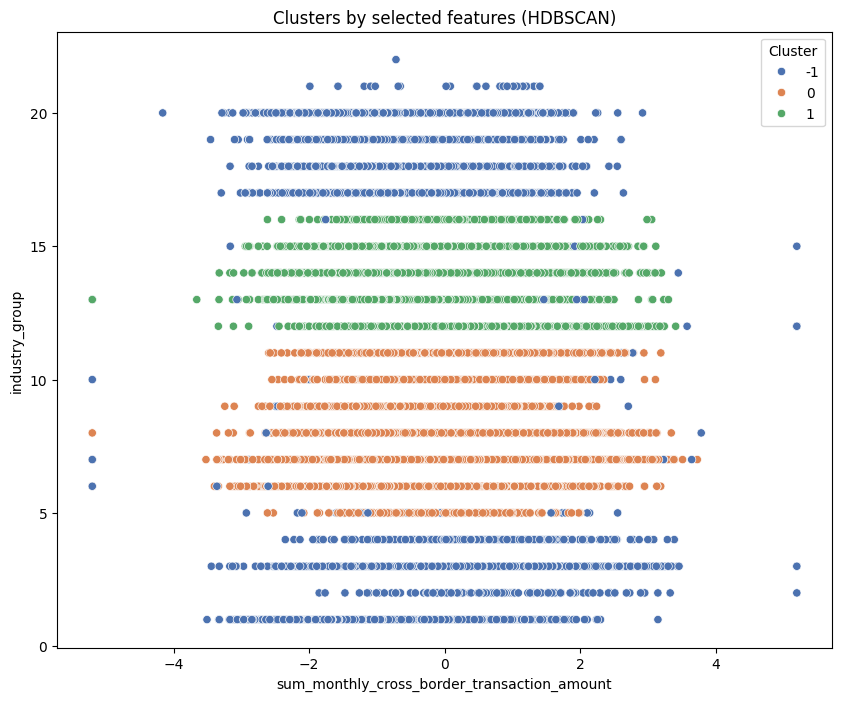

In [ ]:
# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=df_segm_pca_hdbscan,
    x='sum_monthly_cross_border_transaction_amount',
    y='industry_group',
    hue='Cluster',
    palette="deep"
)
plt.title('Clusters by selected features (HDBSCAN)')
plt.show()